In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc

from constants import CONSTS as CS

In [105]:
CS = {
    'x_lim': np.array([-10, 10]),
    'y_lim': np.array([-10, 10]),
    'theta_lim': np.array([-np.pi, np.pi]),
    'xp_lim': np.array([-15, 15]),
    'yp_lim': np.array([-15, 15]),
    'num_waypoints': 10,
    'waypoint_tol': 0.2,
    'angle_tol': 0.2,
    'wheelbase': 0.335,
    'max_acc': 3,
    'max_steering_angle': 0.5,
    'max_vel': 10
}


In [114]:
wps = np.array([
        [0, 0, 0],
        [ 8.62844369,  4.89809566,  1.53850753],
        [-3.3128731 , -8.41245037,  0.2807953 ],
        [ 6.42118345,  9.56369873, -0.52140243],
        [-3.55531364, -7.33024669, -0.58341082],
        [-4.72198946, -4.64057374, -1.95494644],
        [-1.21513531, -4.07460913, -1.61876955],
        [-4.51332572,  9.87373577,  0.22790191],
        [-6.26747526, -9.75024744, -1.55346495],
        [ 7.99872313, -0.73949926, -2.41688927],
        [-9.2515838 ,  6.51287078, -0.61068366]
])

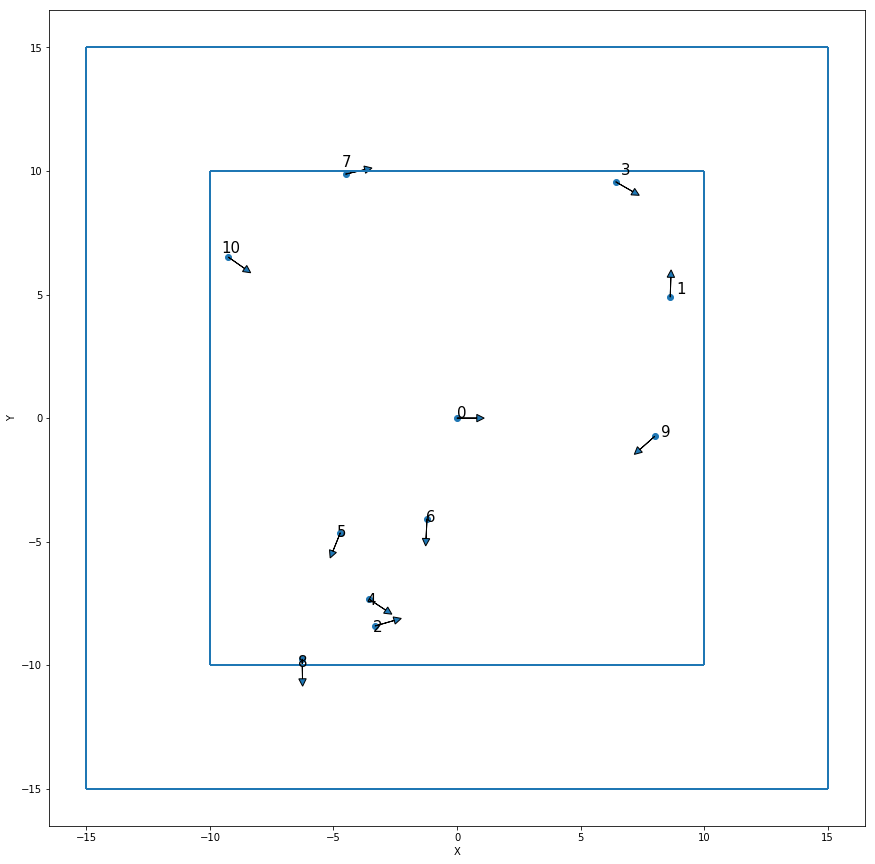

In [115]:
arrow_length = 0.8

plt.figure(figsize=(15, 15))
ax = plt.gca()

plt.scatter(wps[:, 0], wps[:, 1])
for i, wp in enumerate(wps):
    tip = arrow_length * np.array([np.cos(wp[2]), np.sin(wp[2])])
    ax.arrow(wp[0], wp[1], tip[0], tip[1], head_width=0.3, head_length=0.3)
    
    ax.text(wp[0] * 1.03, wp[1] * 1.03, '{}'.format(i), fontsize=15)

lines = [
    [(CS['x_lim'][0], CS['y_lim'][0]), (CS['x_lim'][0], CS['y_lim'][1])], 
    [(CS['x_lim'][0], CS['y_lim'][0]), (CS['x_lim'][1], CS['y_lim'][0])], 
    [(CS['x_lim'][1], CS['y_lim'][1]), (CS['x_lim'][0], CS['y_lim'][1])], 
    [(CS['x_lim'][1], CS['y_lim'][1]), (CS['x_lim'][1], CS['y_lim'][0])], 
    [(CS['xp_lim'][0], CS['yp_lim'][0]), (CS['xp_lim'][0], CS['yp_lim'][1])], 
    [(CS['xp_lim'][0], CS['yp_lim'][0]), (CS['xp_lim'][1], CS['yp_lim'][0])], 
    [(CS['xp_lim'][1], CS['yp_lim'][1]), (CS['xp_lim'][0], CS['yp_lim'][1])], 
    [(CS['xp_lim'][1], CS['yp_lim'][1]), (CS['xp_lim'][1], CS['yp_lim'][0])], 
]
lc = mc.LineCollection(lines, linewidths=2)
ax.add_collection(lc)

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(CS['xp_lim'] * 1.1)
plt.ylim(CS['yp_lim'] * 1.1)

ax.set_aspect('equal')
plt.show()

In [129]:
def cubic_hermite(ts, x0, x1, v0, v1):
    '''
    From https://www.rose-hulman.edu/~finn/CCLI/Notes/day09.pdf
    '''
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = 1 - 3*t2 + 2*t3
    H1 = ts - 2*t2 + t3
    H2 = -t2 + t3
    H3 = 3*t2 - 2*t3
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1

def cubic_hermite_d(ts, x0, x1, v0, v1):
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = - 6*ts + 6*t2
    H1 = np.ones_like(ts) - 4*ts + 3*t2
    H2 = -2*ts + 3*t2
    H3 = 6*ts - 6*t2
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1    

In [130]:
cur_x = np.array([0, 0])
cur_v = np.array([1, 0])

trajs = []
d_trajs = []
speed = 30
n_pts = 100
ts = np.linspace(0, 1, n_pts)

vs = np.c_[np.cos(wps[:,2]), np.sin(wps[:,2])]
for i, wp in enumerate(wps):
    next_x = wp[:2]
    next_v = speed * vs[i]
    if i == len(wps) - 1:
        next_v *= 0
    
    traj = cubic_hermite(ts, cur_x, next_x, cur_v, next_v)
    trajs.append(traj)
    
    d_traj = cubic_hermite_d(ts, cur_x, next_x, cur_v, next_v)
    d_trajs.append(d_traj)
    
    cur_x, cur_v = next_x, next_v    

trajs = np.array(trajs)
d_trajs = np.array(d_trajs)

In [131]:
def plot_trajs(trajs, d_trajs):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()

    for i, traj in enumerate(trajs):
        plt.scatter(traj[:,0], traj[:,1])

        for j, pt in enumerate(traj):
            d_pt = d_trajs[i, j] * 0.05
            ax.arrow(pt[0], pt[1], d_pt[0], d_pt[1], head_width=0.2, head_length=0.2)

    ax.set_aspect('equal')
    plt.show()

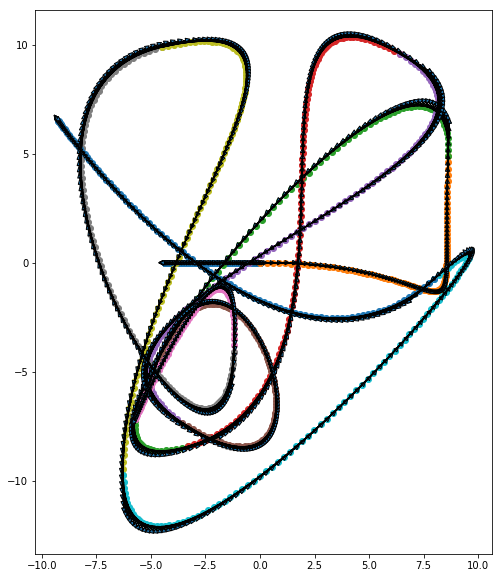

In [132]:
plot_trajs(trajs, d_trajs)

In [119]:
import torch
from torch.autograd import grad
from torch_utils import from_numpy, get_numpy, ones, tensor, zeros_like

In [288]:
def cubic_hermite(ts, x0, x1, v0, v1):
    '''
    From https://www.rose-hulman.edu/~finn/CCLI/Notes/day09.pdf
    '''
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = 1 - 3*t2 + 2*t3
    H1 = ts - 2*t2 + t3
    H2 = -t2 + t3
    H3 = 3*t2 - 2*t3
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1

def cubic_hermite_d(ts, x0, x1, v0, v1):
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = - 6*ts + 6*t2
    H1 = ones(len(ts)) - 4*ts + 3*t2
    H2 = -2*ts + 3*t2
    H3 = 6*ts - 6*t2
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1    

In [405]:
# define params
wps_trch = tensor(wps, requires_grad=True)
wp_speeds = tensor(np.ones(len(wps) - 2) * 30, requires_grad=True)
seg_times = tensor(np.ones(len(wps) - 1) * 10, requires_grad=True)

# define bounds
wps_delta = from_numpy(np.array([CS['waypoint_tol'], CS['waypoint_tol'], np.deg2rad(CS['angle_tol'])]))
wps_lo, wps_hi = wps_trch - wps_delta, wps_trch + wps_delta

seg_times_lo = from_numpy(np.linalg.norm(wps[1:, :2] - wps[:-1, :2], axis=1) / CS['max_vel'])

seg_speed_lo, seg_speed_hi = from_numpy(np.array(0)), from_numpy(np.array(CS['max_vel']))

trajs_lo, trajs_hi = from_numpy(CS['xyp_lims_lo']), from_numpy(CS['xyp_lims_hi'])

In [406]:
# hyperparams
n_pts = 40
constraint_weights = from_numpy(np.array([0.01, 1, 0.0001, 0.001, 0.1, 0.1]))

In [414]:
def gen_trajs(wps, wp_speeds, n_pts):
    trajs = []
    d_trajs = []

    ts = from_numpy(np.linspace(0, 1, n_pts))
    
    vs = torch.stack([torch.cos(wps[:,2]), torch.sin(wps[:,2])]).transpose(0, 1)
    vs[0] *= 1e-2
    vs[1:-1] *= torch.unsqueeze(wp_speeds, 1)
    vs[-1] *= 1e-2
    
    for i in range(1, len(wps)):
        cur_x, cur_v = wps[i - 1, :2], vs[i - 1]
        next_x, next_v = wps[i, :2], vs[i]

        traj = cubic_hermite(ts, cur_x, next_x, cur_v, next_v)
        trajs.append(traj)

        d_traj = cubic_hermite_d(ts, cur_x, next_x, cur_v, next_v)
        d_trajs.append(d_traj)

    trajs = torch.stack(trajs)
    d_trajs = torch.stack(d_trajs)
    
    return trajs, d_trajs

In [415]:
trajs, d_trajs = gen_trajs(wps_trch, wp_speeds, n_pts)

In [416]:
velocities = d_trajs / torch.unsqueeze(torch.unsqueeze(seg_times, 1), 1)

speeds = torch.norm(velocities, dim=2)
accelerations = (speeds[:, 1:] - speeds[:, :-1]) / torch.unsqueeze(seg_times, 1) * n_pts

angles = torch.atan2(trajs[:,:,1], trajs[:,:,0])
betas = torch.asin(torch.tanh(CS['wheelbase'] / 2 * angles / speeds))
steering_angles = torch.atan(2 * torch.tan(betas))

velocities_pred = torch.unsqueeze(speeds, 2) * torch.cat([
                                                        torch.unsqueeze(torch.cos(angles + betas), 2), 
                                                        torch.unsqueeze(torch.sin(angles + betas), 2)
                                                        ], 2)

In [418]:
total_time = torch.sum(seg_times)

constraint_costs = torch.stack([
    # dynamics
    torch.norm(velocities_pred - velocities),
    # steering angle
    torch.sum(torch.relu(torch.pow(steering_angles, 2) - CS['max_steering_angle']**2)),
    # acceleration
    torch.sum(torch.relu(torch.pow(accelerations, 2) - CS['max_acc']**2)),
    # speed
    torch.sum(torch.relu(torch.pow(speeds, 2) - CS['max_vel']**2)),
    # traj bounds
    torch.norm(torch.relu(trajs - trajs_hi)),
    torch.norm(torch.relu(-trajs + trajs_lo))    
])

constraint_cost = constraint_costs @ constraint_weights
loss = total_time + constraint_cost

In [419]:
print(grad(loss, wps_trch, retain_graph=True))
print(grad(loss, seg_times, retain_graph=True))
print(grad(loss, wp_speeds, retain_graph=True))

(tensor([[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [-3.2806e-02,  2.6781e-02,  4.9213e-01],
        [ 3.8544e-03,  5.8044e-03,  5.4653e-03],
        [-3.3162e-01,  4.6161e-02, -1.2427e+00],
        [ 6.1931e-01,  1.1395e+00,  6.4330e+00],
        [-1.8839e+00,  5.4564e-01,  7.4769e-02],
        [ 6.2704e-02,  2.1826e-02, -1.6383e-02],
        [-3.6069e-03, -4.1631e-03, -4.2538e-03],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]]),)
(tensor([1.1524, 1.0355, 0.9923, 0.9905, 1.3785, 2.6202, 1.0888, 0.9932, 0.9895,
           nan]),)
(tensor([    nan, -0.0034,  0.0009, -0.0856, -0.3330, -0.0108, -0.0182,  0.0007,
            nan]),)


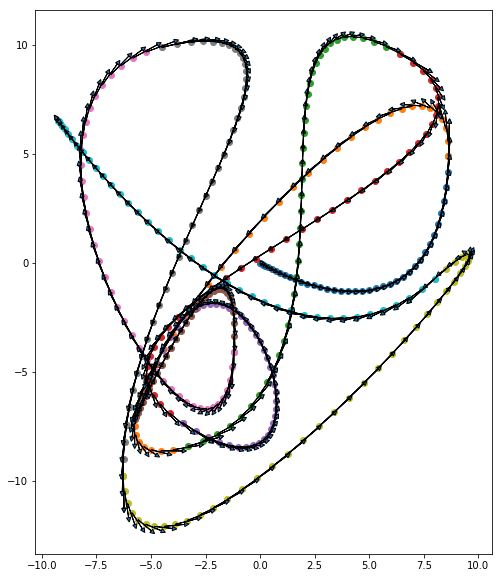

In [421]:
plot_trajs(get_numpy(trajs), get_numpy(d_trajs))